# **Degron - E3 Ligases Interaction Prediction**

### **Author:** Saeedeh Davoudi
### **Date:** 05/05/2023
#### **Description:** In this project, we explore the task of predicting degron-E3 interactions using a deep learning approach. Specifically, we use a pre-trained BERT language model and fine-tune it on a dataset of degron-E3 pairs that we have gathered. We formulate the problem as a question-answering task, where the model takes in a pair of degron and E3 as input and outputs a binary prediction (1 if they are interacting, 0 if they are not). By leveraging the power of transfer learning from the pre-trained BERT model, we aim to improve the accuracy of degron-E3 interaction prediction, which can have important implications for understanding protein degradation pathways and developing therapeutic interventions for diseases.
#### **Next steps:**

 1. **Data augmentation:** Large language models require bigger training data to achieve acceptable performance. We could perform more data augmentation to generate additional training examples and potentially improve the model's performance.

 2. **Optimizing hyperparameters on a more powerful system:** The current model was trained on a personal system without any GPUs available, leading to a limited number of epochs. By running the model on a high-performance GPU/CPU cluster, we can experiment with more epochs and better hyperparameter tuning.

 3. **Utilizing specialized pre-trained models:** I used a base pre-trained BERT model, which was trained on regular English text. However, since our task involves protein sequences, it might be more beneficial to use models pre-trained on protein sequences, such as protein-BERT or GLM4EC models. Due to system limitations, I were unable to load protein-BERT on the personal laptop, but a more powerful system could potentially enable the use of such specialized models.

 4. **Exploring alternative approaches:** I encountered multiple solutions that utilized graph neural networks to solve similar problems. Although I have not used this approach ourselves, it could be a promising candidate for further research and development in predicting degron-E3 interactions.

##### **Git repo:** https://github.com/davoudisaeedeh/E3DegronInteraction.git 

# Libraries

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
torch.cuda.is_available()



False

# Dataset
1. E3-substrates-interactions file is downloaded from : http://ubibrowser.bio-it.cn/ubibrowser_v3/home/download
2. Collected_degrons file is downloaded from: http://degron.phasep.pro/download/ 

In [2]:
'''Convert E3-substrates-interactions text file to Excel file'''
# read in the text file using pandas
df = pd.read_csv('../datasets/E3-substrates-interactions.txt', delimiter='\t')

# write the dataframe to an Excel file
df.to_excel('../datasets/E3-substrates-interactions.xlsx', index=False)

# Tokenization

In [5]:
class AATokenizer:
    """
    Tokenizes amino acid sequences.

    This class tokenizes amino acid sequences using a vocabulary of 21
    amino acids and four additional tokens: <OTHER>, <START>, <END>,
    and <PAD>. The <OTHER> token is used for amino acids that are not
    included in the vocabulary. The <START> and <END> tokens are used
    to mark the beginning and end of the sequence, respectively. The
    <PAD> token is used to pad the sequences to a uniform length.

    Attributes
    ----------
    AAs : str
        String containing the 21 amino acids.
    ADDITIONAL_TOKENS : list
        List containing the names of the four additional tokens.
    ADDED_TOKENS_PER_SEQ : int
        The number of additional tokens added to each sequence.

    Methods
    -------
    __init__()
        Initializes the AATokenizer object.
    tokenize(seq, seq_len)
        Tokenizes the input sequence.

    """
    AAs = 'ACDEFGHIKLMNPQRSTUVWXY'
    ADDITIONAL_TOKENS = ['<OTHER>', '<START>', '<END>', '<PAD>']
    ADDED_TOKENS_PER_SEQ = 2

    def __init__(self):
        self.n_aas = len(self.AAs)
        self.aa_to_token_index = {aa: i for i, aa in enumerate(self.AAs)}
        self.additional_token_to_index = {token: i + self.n_aas for i, token in enumerate(self.ADDITIONAL_TOKENS)}
        self.token_to_index = {**self.aa_to_token_index, **self.additional_token_to_index}
        self.index_to_token = {index: token for token, index in self.token_to_index.items()}
        self.n_tokens = len(self.token_to_index)

    def tokenize(self, seq, seq_len):
        other_token_index = self.additional_token_to_index['<OTHER>']
        tokens = [self.additional_token_to_index['<START>']] + [self.aa_to_token_index.get(aa, other_token_index) for aa in self.parse_seq(seq)] + [self.additional_token_to_index['<END>']]
        return np.array(tokens + (seq_len - len(tokens)) * [self.additional_token_to_index['<PAD>']], dtype=np.int32)

    @staticmethod
    def parse_seq(seq):
        if isinstance(seq, str):
            return seq
        elif isinstance(seq, bytes):
            return seq.decode('utf8')
        else:
            raise TypeError(f'Unexpected sequence type: {type(seq)}')

tokenize_seq = AATokenizer()

# Preprocessing
1. Read the datasets
2. Remove the rows with nan or invalid IDs on Entry column in degrons, and unreviewd on their Status column
3. Remove the rows with nan or invalid IDs on both SwissProt AC (Substrate) and SwissProt AC (E3) columns
4. Merge them together on Entry to a final dataset
5. Keep needed columns: SwissProt AC (Substrate), SwissProt AC (E3), protein seq, start, end, deg_seq, E3_sequence
6. Explode the rows containing # in their E3
7. Add E3 sequences to the dataframe
8. Groupby the final dataset to merge rows with the same substrate 

In [20]:
# Read in the xlsx files using pandas
degrons = pd.read_excel('../datasets/collected_degrons.xlsx')
interactions = pd.read_excel('../datasets/E3-substrates-interactions.xlsx')
E3_sequences = pd.read_excel('../datasets/uniprot-E3.xlsx')

# Remove rows from both dataframes that have NaN or invalid ids
degrons = degrons[(degrons['Entry'].notnull()) & (degrons['Entry'] != '-')]
degrons = degrons[degrons['Status'] != 'unreviewd']

# Remove the rows with nan or invalid IDs on both SwissProt AC (Substrate) and SwissProt AC (E3) columns
interactions = interactions[(interactions['SwissProt AC (Substrate)'].notnull()) & (interactions['SwissProt AC (Substrate)'] != '-')]
interactions = interactions[(interactions['SwissProt AC (E3)'].notnull()) & (interactions['SwissProt AC (E3)'] != '-')]

# Merge them together on Entry to a final dataset
final = pd.merge(degrons, interactions, left_on='Entry', right_on='SwissProt AC (Substrate)')
final = pd.merge(final, E3_sequences, left_on='SwissProt AC (E3)', right_on='Entry')

# Keep needed columns: SwissProt AC (Substrate), SwissProt AC (E3), protein seq, start, end, deg_seq
final = final[['SwissProt AC (Substrate)', 'SwissProt AC (E3)', 'protein seq', 'start', 'end', 'deg_seq', 'E3_sequence']]
final.columns = ['substrate', 'E3', 'substrate protein seq', 'start', 'end', 'degron_seq', 'E3_sequence']
final = final.assign(E3=final['E3'].str.split('#')).explode('E3')
final = final.drop_duplicates(subset=['substrate', 'E3'], keep='first')

# Creat a map to store degrons and their corresponding substrates
degron_substrate = {}
for index, row in final.iterrows():
    if row['degron_seq'] not in degron_substrate:
        degron_substrate[row['degron_seq']] = row['substrate']
        
#Save the degron_substrate dictionary to a csv file
with open('../datasets/degron_substrate.csv', 'w') as f:
    for key in degron_substrate.keys():
        f.write("%s,%s\n"%(key,degron_substrate[key]))

# Creat a dictionary to store the E3s and their corresponding E3 sequences
E3_sequence = {}
for index, row in final.iterrows():
    if row['E3'] not in E3_sequence:
        E3_sequence[row['E3']] = row['E3_sequence']

# Save the E3_sequence dictionary to a csv file
with open('../datasets/E3_sequence.csv', 'w') as f:
    for key in E3_sequence.keys():
        f.write("%s,%s\n"%(key,E3_sequence[key]))

# Groupby the final dataset to merge rows with the same substrate 
#final = final.groupby(['substrate', 'substrate protein seq', 'start', 'end', 'degron_seq']).agg({'E3': lambda x: ';'.join(x), 'E3_sequence': lambda x: ';'.join(x)}).reset_index()

# Write the final dataset to an Excel file
final.to_excel('../datasets/final.xlsx', index=False)

In [21]:
# Test and train split
train, test = train_test_split(final, test_size=0.2, random_state=42)

# Remove substrate protein seq, start, end columns from both train and test datasets
train = train.drop(columns=['substrate protein seq', 'start', 'end'])
test = test.drop(columns=['substrate protein seq', 'start', 'end'])

#Print the size of the train and test datasets
print(train.shape)
print(test.shape)

# Write the train and test datasets to Excel files
train.to_csv('../datasets/train.csv', index=False)
test.to_csv('../datasets/test.csv', index=False)

(395, 4)
(99, 4)


In [3]:
# Read train and test datasets
train = pd.read_csv('../datasets/train.csv')
test = pd.read_csv('../datasets/test.csv')

print(train.head())
print(test.head())

train_degrons = train["degron_seq"].tolist()
train_E3s = train["E3_sequence"].tolist()

test_degrons = test["degron_seq"].tolist()
test_E3s = test["E3_sequence"].tolist()

  substrate      E3      degron_seq  \
0    Q16665  P00748  LAPAAGDTIISLDF   
1    P17181  Q9Y297          DSGNYS   
2    Q16665  P10523  LAPAAGDTIISLDF   
3    P35659  Q969H0           ADSST   
4    Q13002  Q6TDP4           APVIV   

                                         E3_sequence  
0  MRALLLLGFLLVSLESTLSIPPWEAPKEHKYKAEEHTVVLTVTGEP...  
1  MDPAEAVLQEKALKFMCSMPRSLWLGCSSLADSMPSLRCLYNPGTG...  
2  MAASGKTSKSEPNHVIFKKISRDKSVTIYLGNRDYIDHVSQVQPVD...  
3  MNQELLSVGSKRRRTGGSLRGNPSSSQVDEEQMNRVVEEEQQQQLR...  
4  MQPRSERPAGRTQSPEHGSPGPGPEAPPPPPPQPPAPEAERTRPRQ...  
  substrate      E3 degron_seq  \
0    P46527  Q5XPI4   SVEQTPKK   
1    Q14247  Q75N03      ADYRE   
2    P14635  Q86WB0  PRTALGDIG   
3    O00429  Q9NX47    RKRLPVT   
4    P24864  O43791    LLTPPQS   

                                         E3_sequence  
0  MASKGAGMSFSRKSYRLTSDAEKSRVTGIVQEKLLNDYLNRIFSSS...  
1  MDHTDNELQGTNSSGSLGGLDVRRRIPIKLISKQANKAKPAPRTQR...  
2  MAAPCEGQAFAVGVEKNWGAVVRSPEGTPQKIRQLIDEGIAPEEGG...  
3  MPDQALQ

In [6]:
# Process the data
def process_data(data, max_degron_len=8, max_E3_len=128, mode='train'):
    """
    Preprocesses the input data to generate training pairs for the model.

    Parameters
    ----------
    data : pandas DataFrame
        The input data containing the degron and E3 ligase sequences.
    max_degron_len : int, optional
        The maximum length of the degron sequence. Default is 8.
    max_E3_len : int, optional
        The maximum length of the E3 ligase sequence. Default is 128.
    mode : str, optional
        The mode of the function. If mode is 'train', generates negative
        training pairs by permuting the positive pairs. Default is 'train'.

    Returns
    -------
    pandas DataFrame
        A DataFrame containing the degron sequence, E3 ligase sequence, and
        label (1 for positive pairs and 0 for negative pairs).

    """
    pairs = []
    for i, row in data.iterrows():
        pairs.append((row['degron_seq'][:max_degron_len-2], row['E3_sequence'][:max_E3_len-2], 1))

    if mode == 'train':
        negative_pairs = []
        existing_pairs = set((pair[0], pair[1]) for pair in pairs)

        num_negative_pairs = 0
        for i in range(len(pairs)):
            if num_negative_pairs >= len(pairs):
                break
            for j in range(i + 1, len(pairs)):
                if (pairs[i][0], pairs[j][1]) not in existing_pairs:
                    negative_pairs.append((pairs[i][0], pairs[j][1], 0))
                    existing_pairs.add((pairs[i][0], pairs[j][1]))
                    num_negative_pairs += 1
                if num_negative_pairs >= len(pairs):
                    break
                if (pairs[j][0], pairs[i][1]) not in existing_pairs:
                    negative_pairs.append((pairs[j][0], pairs[i][1], 0))
                    existing_pairs.add((pairs[j][0], pairs[i][1]))
                    num_negative_pairs += 1
                if num_negative_pairs >= len(pairs):
                    break

        pairs += negative_pairs

    return pd.DataFrame(pairs, columns=['degron_seq', 'E3_sequence', 'label'])

processed_data = process_data(train)

# Define the dataset class
class DegrE3Dataset(Dataset):
    def __init__(self, data, tokenizer, max_degron_len=8, max_E3_len=128):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = {'degron_seq': max_degron_len, 'E3_sequence': max_E3_len}

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        degron_seq = self.data.loc[idx, 'degron_seq']
        E3_sequence = self.data.loc[idx, 'E3_sequence']
        label = self.data.loc[idx, 'label']
        
        degron_tokens = self.tokenizer.tokenize(degron_seq, self.max_len['degron_seq'])
        E3_tokens = self.tokenizer.tokenize(E3_sequence, self.max_len['E3_sequence'])

        return torch.tensor(degron_tokens), torch.tensor(E3_tokens), torch.tensor(label, dtype=torch.float32)


# Create the dataset and dataloader
dataset = DegrE3Dataset(processed_data, tokenize_seq)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Model Training

In [11]:
def train(model, dataloader, criterion, optimizer, scheduler, device, num_epochs=10):
    """
    Train a language model using the given dataset.

    Parameters
    ----------
    model : torch.nn.Module
        The model to be trained.
    dataloader : torch.utils.data.DataLoader
        The dataloader for the dataset.
    criterion : torch.nn.Module
        The loss function.
    optimizer : torch.optim.Optimizer
        The optimizer.
    scheduler : torch.optim.lr_scheduler._LRScheduler
        The learning rate scheduler.
    device : torch.device
        The device to be used for training (e.g. CPU or GPU).
    num_epochs : int, optional
        The number of epochs to train the model for.

    Returns
    -------
    model : torch.nn.Module
        The trained model.

    """
    model = model.to(device)
    model.train()
    
    for epoch in range(num_epochs):
        total_loss = 0
        for degron_tokens, E3_tokens, labels in dataloader:
            degron_tokens, E3_tokens, labels = degron_tokens.to(device), E3_tokens.to(device), labels.to(device)
            
            inputs = torch.cat((degron_tokens, E3_tokens), dim=-1)
            optimizer.zero_grad()
            outputs = model(inputs).logits.squeeze()
            loss = criterion(torch.sigmoid(outputs), labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss:.4f}")

    return model

num_epochs = 10
# Initialize the pre-trained BERT model and tokenizer
# Rostlab/prot_bert
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)

# Change the input size to BERT's hidden size
input_size = model.config.hidden_size
criterion = nn.BCELoss()

# Initialize the optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(dataloader) * num_epochs)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trained_model = train(model, dataloader, criterion, optimizer, scheduler, device, num_epochs)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch 1/10, Train Loss: 0.7004
Epoch 2/10, Train Loss: 0.7000
Epoch 3/10, Train Loss: 0.6921
Epoch 4/10, Train Loss: 0.6968
Epoch 5/10, Train Loss: 0.6986
Epoch 6/10, Train Loss: 0.6931
Epoch 7/10, Train Loss: 0.6961
Epoch 8/10, Train Loss: 0.6961
Epoch 9/10, Train Loss: 0.6963
Epoch 10/10, Train Loss: 0.6929


In [12]:
# Save the trained model
torch.save(trained_model.state_dict(), '../models/trained_model.pt')

# Model Evaluation

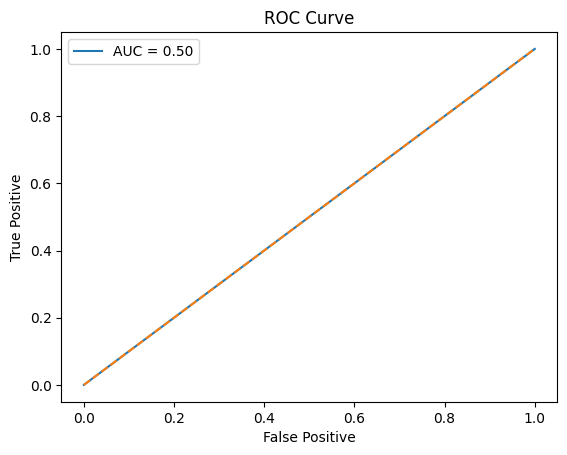

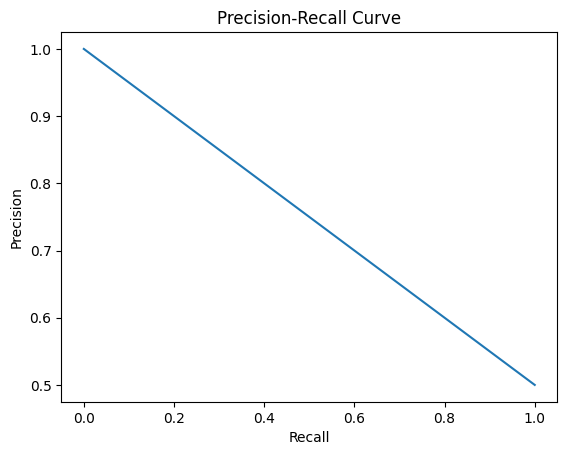

Test loss: 0.693047046661377, Test accuracy: 0.5, AUC: 0.5, Outputs: [tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True]), tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True]), tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True]), tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True]), tensor([True, True, True, True, True, True, True, True, Tr

In [13]:
def evaluate(model, dataloader):
    """
    Evaluate a PyTorch model on a given dataloader.

    Parameters
    ----------
    model : torch.nn.Module
        The PyTorch model to evaluate.
    dataloader : torch.utils.data.DataLoader
        The dataloader containing the input data for evaluation.

    Returns
    -------
    tuple
        A tuple containing the average loss, accuracy, AUC, and a list of outputs
        for each batch.

    """
    
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    outputs_list = []
    labels_list = []
    
    with torch.no_grad():
        for degron_tokens, E3_tokens, labels in dataloader:
            inputs = torch.cat((degron_tokens, E3_tokens), dim=-1)
            outputs = model(inputs).logits.squeeze()
            total_loss += criterion(torch.sigmoid(outputs), labels).item()
            total_correct += ((torch.sigmoid(outputs) >= 0.5) == labels).sum().item()
            total_samples += len(labels)
            outputs_list.append(torch.sigmoid(outputs) >= 0.5)
            labels_list.append(labels)

    # Convert outputs and labels to NumPy arrays
    outputs_array = torch.cat(outputs_list).cpu().numpy()
    labels_array = torch.cat(labels_list).cpu().numpy()

    # Calculate AUC
    auc_score = roc_auc_score(labels_array, outputs_array)

    # ROC curve
    fpr, tpr, _ = roc_curve(labels_array, outputs_array)
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive')
    plt.ylabel('True Positive')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(labels_array, outputs_array)
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

    return total_loss / len(dataloader), total_correct / total_samples, auc_score, outputs_list


# Process the test data
processed_test_data = process_data(test)

# Create the test dataset and dataloader
test_dataset = DegrE3Dataset(processed_test_data, tokenize_seq)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Evaluate the model on the test data
test_loss, test_acc, auc_score, outputs_list = evaluate(model, test_dataloader)
print(f"Test loss: {test_loss}, Test accuracy: {test_acc}, AUC: {auc_score}, Outputs: {outputs_list}")

# Save Results

In [14]:
def predict_interactions(model, data):

    # Extract the degron_seq and E3_sequence columns
    degron_E3_pairs = data[['degron_seq', 'E3_sequence']]

    # Group by the degron_seq column
    grouped_data = degron_E3_pairs.groupby('degron_seq')

    # Initialize an empty DataFrame to store the results
    results = pd.DataFrame(columns=['degron_seq', 'E3_sequences'])

    model.eval()
    with torch.no_grad():
        for degron, group in grouped_data:
            E3_sequences = []
            for _, row in group.iterrows():
                degron_tokens = tokenize_seq.tokenize(row['degron_seq'], 8)
                E3_tokens = tokenize_seq.tokenize(row['E3_sequence'], 128)

                # Convert NumPy arrays to PyTorch tensors
                degron_tokens = torch.tensor(degron_tokens, dtype=torch.long)
                E3_tokens = torch.tensor(E3_tokens, dtype=torch.long)

                # Concatenate and truncate or pad the input
                max_length = 256
                inputs = torch.cat((degron_tokens, E3_tokens), dim=-1)
                inputs = inputs[:max_length]
                inputs = torch.cat((inputs, torch.zeros(max_length - inputs.shape[0], dtype=torch.long)), dim=0)

                # Add a batch dimension
                inputs = inputs.unsqueeze(0)

                outputs = model(inputs).logits.squeeze()

                if torch.sigmoid(outputs) >= 0.5:
                    E3_sequences.append(row['E3_sequence'])

            new_row = pd.DataFrame({'degron_seq': [degron], 'E3_sequences': [E3_sequences]})
            results = pd.concat([results, new_row], ignore_index=True)

    return results

results = predict_interactions(model, test)
results

,degron_seq,E3_sequences
0,ADSST,[MCNTNMSVPTDGAVTTSQIPASEQETLVRPKPLLLKLLKSVGAQK...
1,ADSTT,[MALPKDAIPSLSECQCGICMEILVEPVTLPCNHTLCKPCFQSTVE...
2,ADYRE,[MDHTDNELQGTNSSGSLGGLDVRRRIPIKLISKQANKAKPAPRTQ...
3,AGSTS,[MAAPDLSTNLQEEATCAICLDYFTDPVMTDCGHNFCRECIRRCWG...
4,ALSSS,[MDPAEAVLQEKALKFMCSMPRSLWLGCSSLADSMPSLRCLYNPGT...
...,...,...
58,RSTLAEL,[MAQFAFESDLHSLLQLDAPIPNAPPARWQRKAKEAAGPAPSPMRA...
59,SEGSDDSGL,[MDPAEAVLQEKALKFMCSMPRSLWLGCSSLADSMPSLRCLYNPGT...
60,SIFDNLYTTLSD,[MAGNVKKSSGAGGGSGSGGSGSGGLIGLMKDAFQPHHHHHHHLSP...
61,SVEQTPKK,[MASKGAGMSFSRKSYRLTSDAEKSRVTGIVQEKLLNDYLNRIFSS...


In [15]:
results.to_csv('../results/results.csv', index=False)